In [1]:
%matplotlib ipympl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Gas costs

Run `python read_data.py` to produce this table in costs.db

In [3]:
con = sqlite3.connect('costs.db')

In [4]:
costs = pd.read_sql('select * from fuel', con, parse_dates='date', index_col=['region', 'amount', 'date'])

In [5]:
vat = .15

In [6]:
lpg = (
    costs
    .loc[:, "Liquefied Petroleum Gas (c/kg)", :]
    .unstack('region')
    ['cost']
    .rename(columns=str.title)
    .sort_index()
)*(1 + vat)

There are two prices - one for "Coastal" and one for "Gauteng" - let's check out the difference

<AxesSubplot: xlabel='date'>

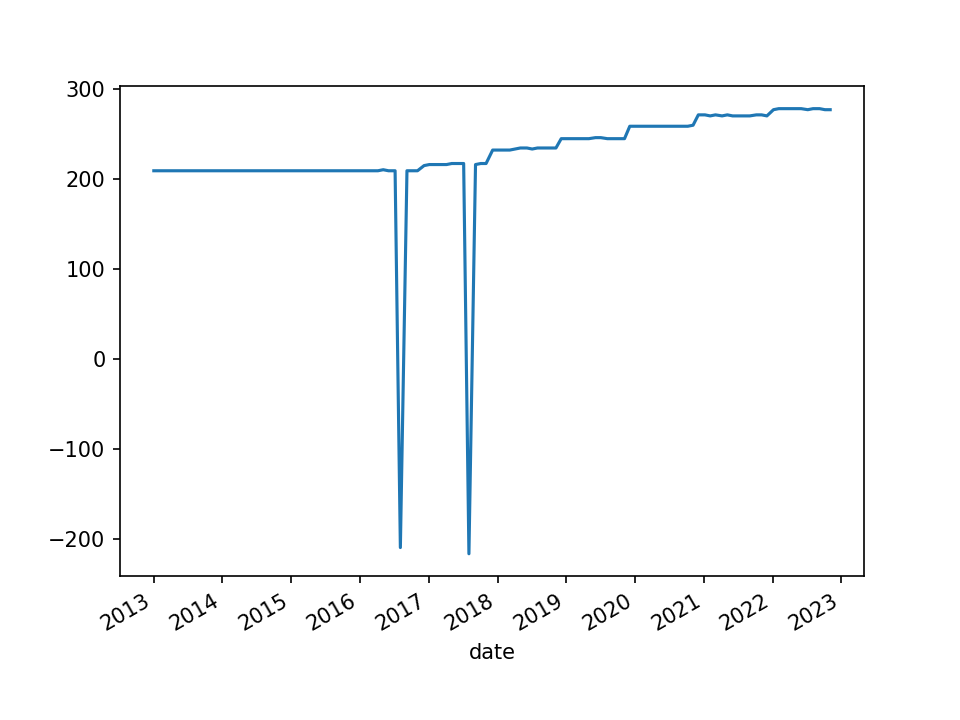

In [7]:
plt.figure()
(lpg['Gauteng']-lpg['Coastal']).plot()

Oops - slight error in the data there. I'm guessing they swapped them by mistake.

In [8]:
swapped_values = lpg['Gauteng'] < lpg['Coastal']
lpg[swapped_values] = lpg[swapped_values].values[:, ::-1]

In [9]:
swapped_values.index[swapped_values]

DatetimeIndex(['2016-08-03', '2017-08-02'], dtype='datetime64[ns]', name='date', freq=None)

(0.0, 281.7500000000002)

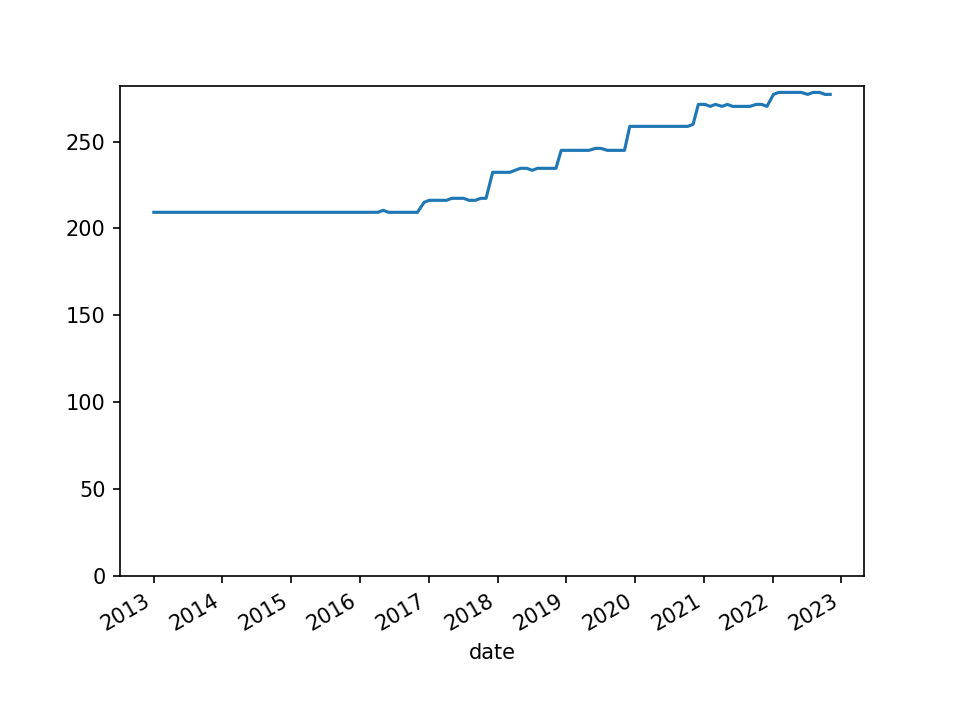

In [10]:
plt.figure()
(lpg['Gauteng']-lpg['Coastal']).plot().set_ylim(bottom=0)

Looks like the Gauteng tarif is bumped up around every year.

In [11]:
def exponential(start, rate, dates):
    v = start
    r = []
    for i in dates:
        r.append(v)
        v *= (1 + rate)
    return pd.Series(r, index=dates)

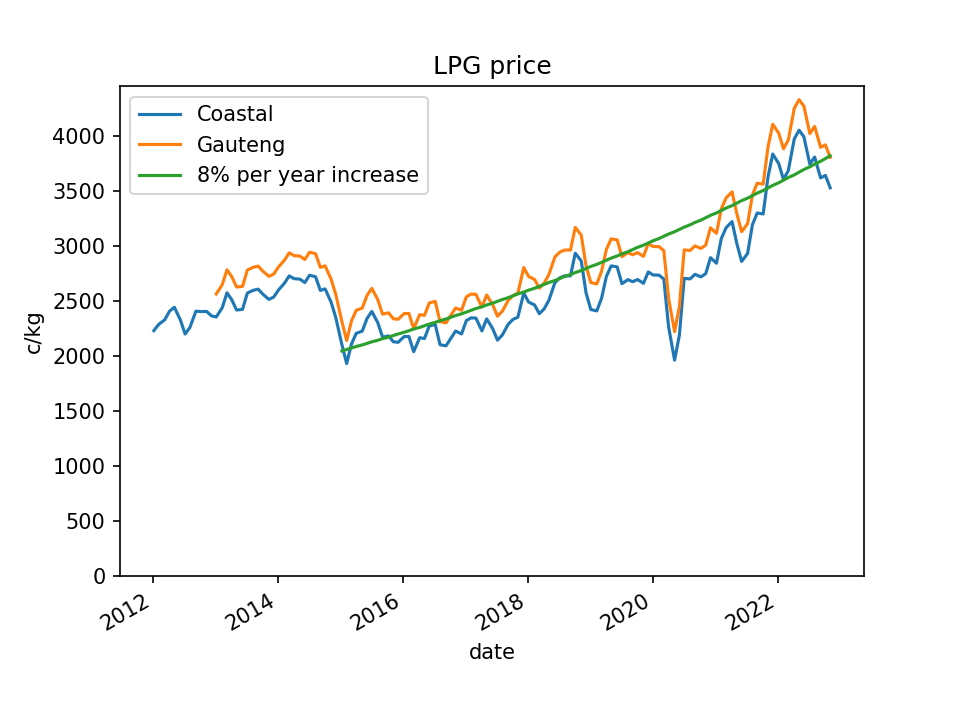

In [12]:
ax = lpg.plot(
    # drawstyle='steps-post',
    title='LPG price',
    ylabel='c/kg',
    xlabel='Date',
    # logy=True,
)
ax.set_ylim(bottom=0)
exponential(1400*(1+vat), 0.08/12, lpg.index)['2015':].plot(ax=ax, label='8% per year increase')
ax.legend()

Since about 2015 gas prices appear to have gone up at approximately 8% per year

# Electricity costs

Eskom handily provides the tarifs in Excel format on [this page](https://www.eskom.co.za/distribution/rates-in-excel-format/). Of course each file is lovingly hand-crafted and not in the same format, but we can automate the downloads at least a bit. [This notebook](Read_Eskom_data.ipynb) does that.


In [13]:
elec = pd.read_sql('select * from electricity', con, parse_dates='Date', index_col='Date')

In [14]:
elec = elec.resample('1MS').max().fillna(method='ffill')

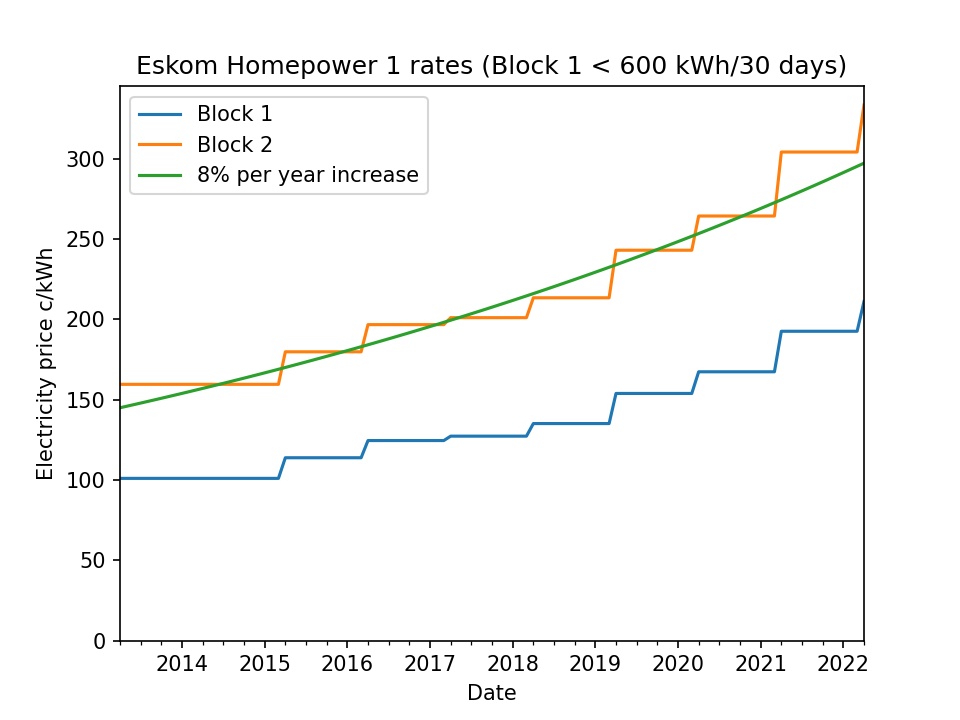

In [15]:
ax = elec.plot(
    title='Eskom Homepower 1 rates (Block 1 < 600 kWh/30 days)',
    ylabel='Electricity price c/kWh',
)
exponential(145, 0.08/12, elec.index).plot(ax=ax, label='8% per year increase')
ax.set_ylim(bottom=0)
ax.legend()

# Comparison

The gas costs we downloaded are quoted in as c/kg, now let's calculate the energy cost. I'll use kWh for easy comparison to electrical cost.

LPG is basically 60% propane and 40% butane in South Africa (see [here](http://www.compcom.co.za/wp-content/uploads/2018/11/Chapter-3.-Background-to-the-LPG-sector-in-South-Africa.pdf)). I will use the heating values quoted on [Wikipedia](https://en.wikipedia.org/wiki/Heat_of_combustion#Heat_of_combustion_tables) listed in MJ/kg.

In [16]:
kWh_per_MJ = 1/3.6

In [17]:
x_propane = 0.6
x_butane = 1 - x_propane

In [18]:
propane_hhv = 50.35
butane_hhv = 49.50
propane_lhv = 46.35
butane_lhv = 45.75

MJ/kg * kWh/MJ = kWh/kg

In [19]:
heating_values = {
    'higher': (x_propane*propane_hhv + x_butane*butane_hhv)*kWh_per_MJ,
    'lower': (x_propane*propane_lhv + x_butane*butane_lhv)*kWh_per_MJ,
}

(0.0, 400.0)

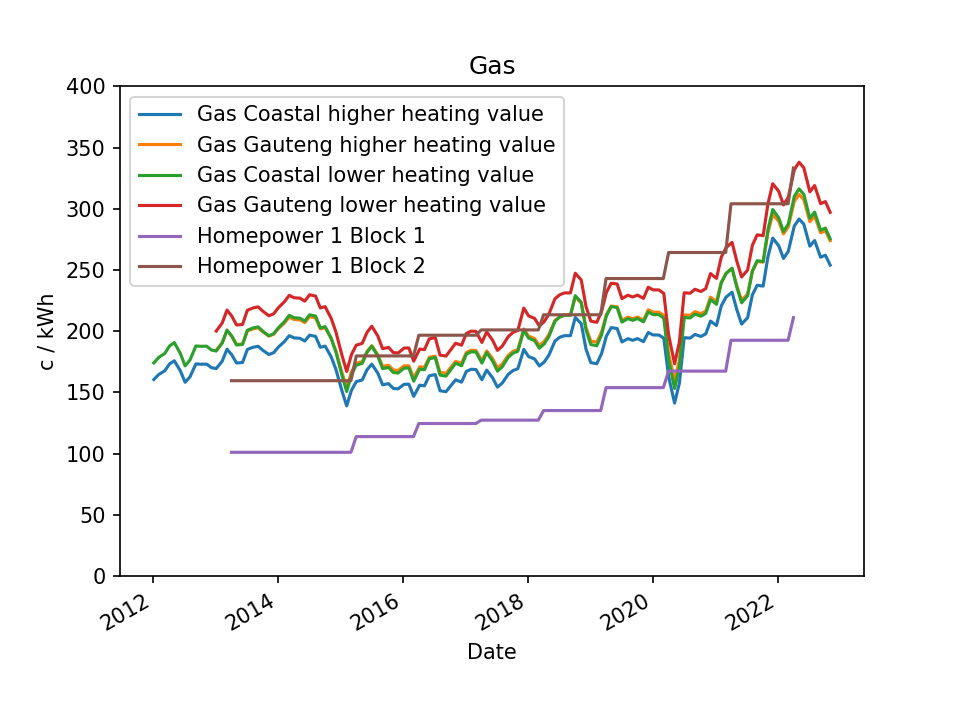

In [38]:
fig, ax = plt.subplots()
for hv_name, hv in heating_values.items():
    (lpg/hv).rename(columns=lambda c: f'Gas {c} {hv_name} heating value').plot(ax=ax, title='Gas')
elec.rename(columns=lambda c: f'Homepower 1 {c}').plot(ax=ax)
ax.set(
    ylabel='c / kWh'
)
ax.legend(title='')
ax.set_ylim(bottom=0, top=400)

In [20]:
heating_values

{'higher': 13.89166666666667, 'lower': 12.808333333333334}

[Text(0, 0.5, 'Electricity/Gas cost ratio')]

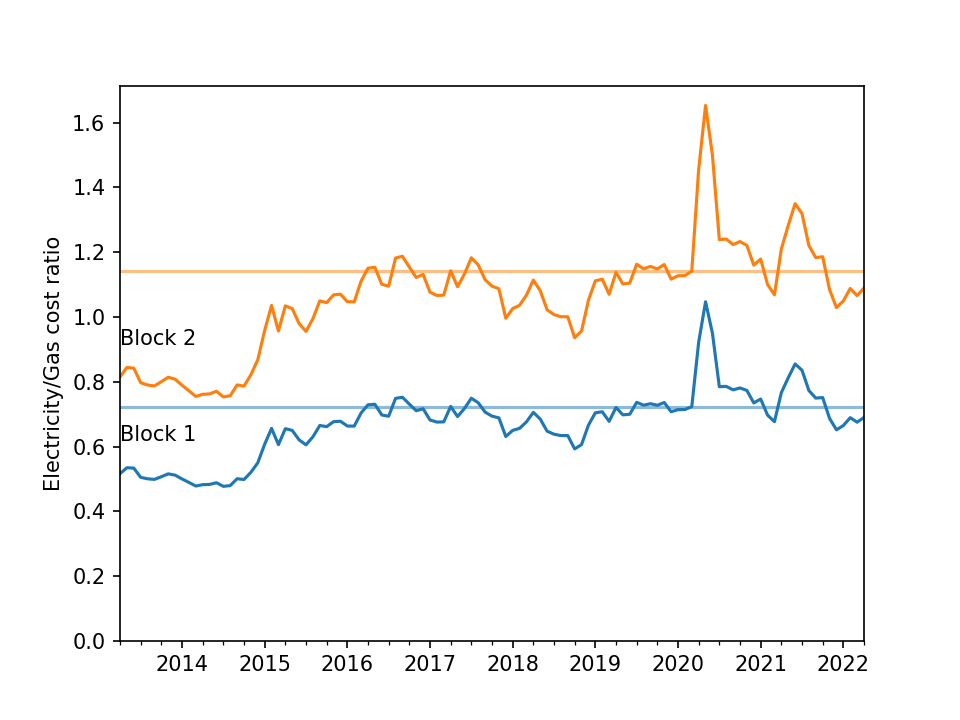

In [21]:
fig, ax = plt.subplots()
hv_name = 'higher'

ratio_table_data = []

for i, rate in enumerate(elec.columns):
    lpg_cost_gauteng = lpg['Gauteng'].resample('1MS').mean()/heating_values[hv_name]
    elec_cost = elec[rate]
    
    ratio = (elec_cost/lpg_cost_gauteng).dropna()
    avg_ratio = ratio.iloc[-5*12:].mean()
    ratio_table_data.append({'Name': rate, 'Ratio': avg_ratio})
    
    ratio.plot(ax=ax)
    ax.axhline(avg_ratio, color=f'C{i}', alpha=0.5)
    
    ax.text(ratio.index[0], ratio.iloc[0]+0.1, rate)
    
ax.set_xlim(ratio.index.min(), ratio.index.max())
ax.set_ylim(bottom=0)
ax.set(
    ylabel='Electricity/Gas cost ratio'
)

In [22]:
# Name, gas heating value, gas efficiency, electrical efficiency
scenarios = [
    ['Geyser (conventional)', 'higher', 0.6, 1],
    ['Geyser (heat pump)', 'higher', 0.6, 4],
    ['Cooking vs induction', 'lower', 0.4, 0.9],
    ['Space heating', 'higher', 0.9, 1],
    ['Space heating (aircon)', 'higher', 0.9, 3],
]

In [23]:
for name, hv, gas_efficiency, elec_efficiency in scenarios:
    ratio_table_data.append({
        'Name': name,
        'Ratio': elec_efficiency/gas_efficiency,
    })

In [24]:
ratio_table = pd.DataFrame(ratio_table_data).set_index('Name').sort_values('Ratio')

In [25]:
ratio_table

,Ratio
Name,
Block 1,0.723386
Space heating,1.111111
Block 2,1.142251
Geyser (conventional),1.666667
Cooking vs induction,2.250000
Space heating (aircon),3.333333
Geyser (heat pump),6.666667


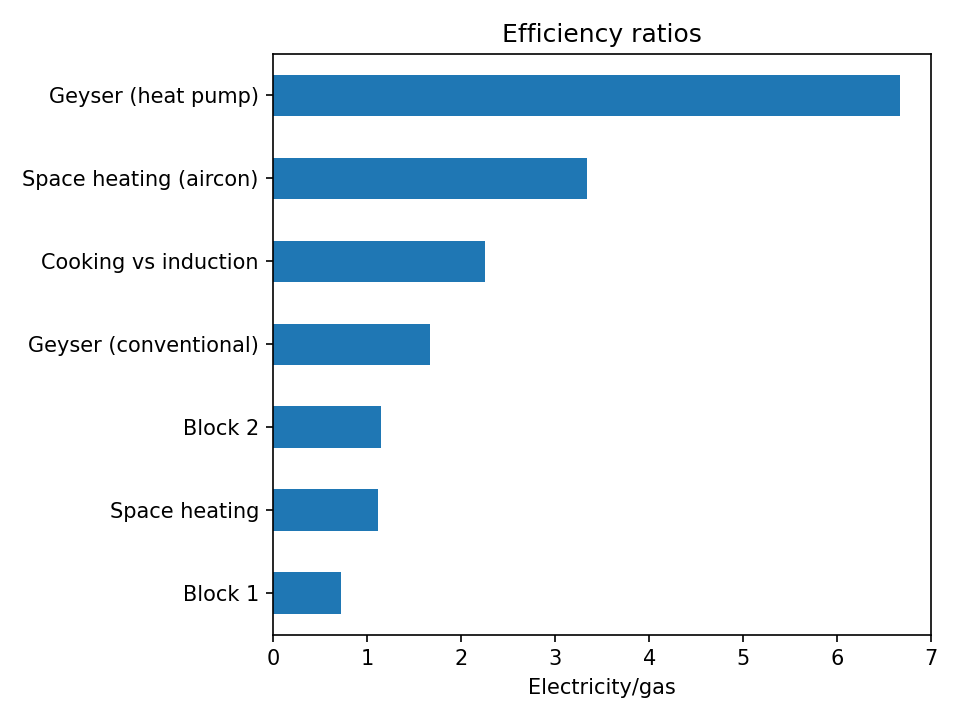

In [26]:
ax = ratio_table.plot.barh(
    legend=False,
    title='Efficiency ratios',
)
ax.set(
    ylabel=None,
    xlabel='Electricity/gas'
)
plt.tight_layout()